### Import Packages

In [2]:
# import the NumPy and PuLP libraries under the aliases np and pl respectively
!pip install numpy
!pip install pulp

import numpy as np
print(np.__version__) # get version
import pulp as pl
print(pl.__version__) # get version
!python --version # get python version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 39.1 MB/s eta 0:00:00
1.23.5
2.7.0
Python 3.10.12


### Program Settings


Defining the Multi-Day Solve Method Components
      
        X: Decision variable matrix representing whether to schedule each visit type on each day.
        D1: List of decision variables representing the number of appointments scheduled on each day.
        D2: List of decision variables representing whether each day is scheduled.
        D: List of decision variables representing the date on which each visit type is scheduled.
        N_scheduled_d: Decision variable representing the total number of scheduled days.
        Leading: Decision variable representing the leading time between appointments.
        m: PuLP Linear Programming problem instance.


Defining the Single Day Solve Method Components

        spread_t: Decision variable representing the spread time of all appointments.
        end_t: Decision variable representing the latest end time of all appointments.
        start_t: Decision variable representing the earliest start time of all appointments.
        total_travel_t: Decision variable representing the total travel time between appointments.
        travel_ts: List of decision variables representing the travel time between resources.
        preference_diff: Decision variable representing the difference from the preferred time slots.
        X: Decision variable matrix representing whether to schedule each resource in each time window.
        X2: List of decision variables representing whether each resource is scheduled.
        Y: Decision variable matrix representing the visit type order constraints.
        m: PuLP Linear Programming problem instance.

In [3]:
class Scheduler():
    # set number of days to be considered to schedule
    N_DAYS = 14
    T_unit = 5
    M = 10**6

    # Initialize the Scheduler class with the parameters defined below
    def __init__(self,N_VT,N_DEP,VT_DEP,JOB_LEN,DIS,T_VT,ST_DEP,ED_DEP,Cap,intv_const = None):
        '''
        parameters:
            N_VT: number of visit types
            N_DEP: number of departments
            VT_DEP: a dictionary stored the visit types and corresponding departments
            JOB_LEN: job length for each visit type (minutes)
            DIS: matrix stores the distances between each 2 departments (minutes), size=(N_VT,N_VT)
            T_VT: length of appointment window for each visit type (minutes)
            ST_DEP: start of business hours for each department (24h)
            ED_DEP: end of business hours for each department (24h)
            Cap: capacity of each resource on each day, {vt1:{dep1:{[[...],[...],...]}},vt2:...)
        '''
        # Constants
        self.N_VT = N_VT
        self.N_DEP = N_DEP
        self.VT_DEP = VT_DEP

        # Map visit type id & department id to resource id; We will regard one visit type at one department as one resource
        self.rsrc_map = dict()
        idx = 0
        for vt in VT_DEP:
            for dep in VT_DEP[vt]:
                self.rsrc_map[idx] = (vt,dep)
                idx += 1
        self.N_RSRC = idx

        self.JOB_LEN = JOB_LEN/T_unit
        self.DIS = DIS/T_unit # Create distance matrix in the scaled unit (minutes) [[j/T_unit for j in DIS] for i in DIS]
        self.T_VT = [t/T_unit for t in T_VT] # Appointment window length for each visit type

        # Convert start and end of business hours to the scaled unit
        min_ST_DEP = min(ST_DEP*60)/T_unit
        self.ST_DEP = [t*60/T_unit-min_ST_DEP for t in ST_DEP]
        self.ED_DEP = [t*60/T_unit-min_ST_DEP for t in ED_DEP]

        self.N_W_RSRC = []

        # Calculate capacity for each resource in each department
        self.Cap = [] #  Capacity of each resource on each day
        for i in range(self.N_RSRC):
            vti,depi = self.rsrc_map[i]
            self.N_W_RSRC.append(int((self.ED_DEP[depi]-self.ST_DEP[depi])/self.T_VT[vti]))
            self.Cap.append(np.array(Cap[vti][depi]))

        self.intv_const = intv_const if intv_const is not None else np.zeros((self.N_VT,self.N_VT))

    def agg_daily_Cap(self):
        '''
        aggregate capacity to daily basis
        return:
            (N_VT, N_DAYS)
        '''
        self.Cap_agg = np.array([i.sum(axis=1) for i in self.Cap])

    def single_day_Cap(self,d):
        return [i[d] for i in self.Cap]

    def _input(self,Req,
               order_pref = None,
               date_pref = None, ts_pref = None,
               unavail_date = None, unavail_ts = None,
               obj_pref = 'spread_time',
               same_date = None,
               pre_win = None):
        '''
        input from the patient/scheduler
        parameters:
            Req: number of appointments for each visit type like {0:1,1:1,2:0}, size=N_VT
            order_pref: matrix that defines order constraint if any, size=(N_VT,N_VT)
                        if order_pref[i,j]=1, visit type i should be scheduled later than visit type j
            date_pref: array of preferred dates [0,3,...]
            ts_pref: array of preferred time slots [1,3,...]
            unavail_date: array of unavailable dates [1,2,...]
            unavail_ts: array of unavailable time slots [1,3,...]
            obj_pref: 'spread_time', 'end_time'
            same_date: matrix that defines whether 2 visit type need to be scheduled on the same day
            pre_win: array of number of days required to scheduled before the appointment
            intv_const: matrix that stores required interval between 2 visit types, size=(N_VT,N_VT)
        '''
        self.Req = Req
        self.order_pref = order_pref
        self.date_pref = date_pref
        self.ts_pref = ts_pref
        self.unavail_date = unavail_date
        self.unavail_ts = unavail_ts
        self.obj_pref = obj_pref
        self.same_date = same_date
        self.pre_win = pre_win

    def visualized_daily_schedule(self, schedule):
        import matplotlib.pyplot as plt
        import seaborn as sns

        plt.figure(figsize=(self.N_DAYS,self.N_VT))
        sns.heatmap(schedule,cmap='Blues',linewidths=1,square=True)
        plt.xticks(range(self.N_DAYS))
        plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
        plt.yticks(range(self.N_VT))
        plt.show()

    def visualized_single_day_schedule(self, schedule):
        import matplotlib.pyplot as plt
        import seaborn as sns

        aligned_sched = []
        max_w = int(max(self.ED_DEP))
        for i in range(self.N_RSRC):
            vt,dep = self.rsrc_map[i]
            aligned_sched.append(np.zeros(max_w))
            st_idx = int(self.ST_DEP[vt])
            ed_idx = int(self.ED_DEP[vt])
            aligned_sched[i][st_idx:ed_idx+1] = np.repeat(schedule[i],self.T_VT[vt])[:ed_idx-st_idx]

        plt.figure(figsize=(max_w,self.N_VT))
        sns.heatmap(aligned_sched,cmap='Blues',linewidths=1,square=True)
        plt.xticks(range(max_w))
        plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
        plt.yticks(range(self.N_VT))
        plt.show()

# Define the Multi-day and Single-day methods of solving the schedule request
# The `LP_multi_day` solve method finds multi-day solutions to the schedule request. The `LP_same_day` solve method finds single day solutions when the multi-day solution does not fully meet the scheduling requirements or preferences.
# Both types of solutions are considered in order to get the optimal result based on our set objective functions and constraints. The `solve` method in the ‘Scheduler’ class stores the solutions in the `res` list as a dictionary containing the optimized schedule, LP model, and other relevant information.
# In short, after obtaining the multi-day solution, the `solve` method then checks if there are specific days when a single-day solution might improve the overall schedule, and if so, appends those to the `res` list.

    def LP_multi_day(self):
        """
        """

        ## Create the PuLP LP
        m = pl.LpProblem('multiple_day_scheduling_optimization', pl.LpMinimize)


        ## Create the decision variables

        # Appointments
        X = [] # Whether to schedule for each visit type each day
        for vt in range(self.N_VT):
            X.append([])
            for d in range(self.N_DAYS):
                X[vt].append(pl.LpVariable(f'X_{vt}_{d}',cat='Binary'))
        X = np.array(X)

        # For objective function
        # Scheduled days
        N_scheduled_d = pl.LpVariable(f'N_scheduled_d',cat='Integer')
        # Number of appointments scheduled to day d
        D1 = []
        # Whether day d is scehduled
        D2 = []
        for d in range(self.N_DAYS):
            D1.append(pl.LpVariable(f'D1_{d}',cat='Integer',lowBound=0))
            D2.append(pl.LpVariable(f'D2_{d}',cat='Binary'))

            m += (D1[d]==pl.lpSum(X[:,d]), f'D1_{d}_constraint')
            m += (D1[d]<=D2[d]+D2[d]*self.M, f'D2_{d}_constraint1')
            m += (D1[d]>=D2[d]-D2[d]*self.M, f'D2_{d}_constraint2')
        m += (N_scheduled_d==pl.lpSum(D2), f'N_scheduled_d_constraint')

        # Leading time
        Leading = pl.LpVariable(f'Leading_days',cat='Integer',lowBound=0)
        # The date visit type vt is scheduled to
        D = []
        for vt in range(self.N_VT):
            D.append(pl.LpVariable(f'D_{vt}',cat='Integer',lowBound=0))
            m += (D[vt]==pl.lpSum([X[vt,d]*d for d in range(self.N_DAYS)]), f'D_{vt}_constraint')
        m += (Leading==pl.lpSum(D)/self.N_VT, f'Leading_time_constraint')


        ## Create the constraints

        # Capacity balance & resource & demand constraints
        scheduled_caps = 0
        for vt in range(self.N_VT):
            for d in range(self.N_DAYS):
                scheduled_caps += self.Cap_agg[vt,d]*X[vt,d]
                m += (X[vt,d]<=self.Cap_agg[vt,d])
                m += (pl.lpSum(X[vt])==self.Req[vt])

        # Order constraint
        if self.order_pref is not None:
            for i in range(self.N_VT):
                for j in range(self.N_VT):
                    if j>i and self.order_pref[i,j]!=-1:
                        m += (D[i]<=D[j]+self.order_pref[i,j]*self.M, f'order_{i}_{j}_constraint1')
                        m += (D[i]>=D[j]-(1-self.order_pref[i,j])*self.M, f'order_{i}_{j}_constraint2')

        # Same day constraint
        if self.same_date is not None:
            for i in range(self.N_VT):
                for j in range(self.N_VT):
                    if j>i and self.same_date[i,j]==1:
                        m += (D[i]==D[j], f'same_day_{i}_{j}_coonstraint')


        ## Objective function favoring minimized spread time then minimized lead time and scheduled capacity
        m += 0.98*N_scheduled_d + 0.019*Leading - 0.001*scheduled_caps

        return X,D1,D2,D,N_scheduled_d,Leading,m


    def LP_same_day(self,day_Cap,Req):

        ## Create the PuLP linear program
        m = pl.LpProblem('scheduling_optimization', pl.LpMinimize)


        ## Create the decision variables

        # appointments
        X = [] # whether schedule for each resource each window
        for i in range(self.N_RSRC):
            X.append([])
            for w in range(self.N_W_RSRC[i]):
                X[i].append(pl.LpVariable(f'X_{i}_{w}',cat='Binary'))
            X[i] = np.array(X[i])

        # For objective function
        # Spread time of all appointments
        spread_t = pl.LpVariable('spread_t',lowBound=0)
        # Travel time
        total_travel_t = pl.LpVariable('travel_time',lowBound=0)
        # Difference from the preferred time slots, if no preference, should be 0
        preference_diff = pl.LpVariable('preference_diff',lowBound=0)

        # Definition of objective variables
        # Start time: earlier than any start time, if no appointments then =N
        # End time: later than latest start time + job length
        start_t = pl.LpVariable('start_t',lowBound=0)
        end_t = pl.LpVariable('end_t',lowBound=0)
        m += (spread_t==end_t-start_t, f'spread_time_constraints')
        for idx in range(self.N_RSRC):
            for k in range(self.N_W_RSRC[idx]):
                vt = self.rsrc_map[idx][0]
                dep = self.rsrc_map[idx][1]
                T = self.T_VT[vt]
                start_bt = self.ST_DEP[dep]
                m += (start_t<=X[idx][k]*k*T+start_bt+(1-pl.lpSum(X[idx][k]))*self.M, f'start_time_{idx}_{k}_constraint')
                m += (end_t>=X[idx][k]*k*T+X[idx][k]*self.JOB_LEN[vt]+start_bt, f'end_time_{idx}_{k}_constraint')

        # Travel time
        travel_ts = []
        Y = []
        X2 = [pl.LpVariable(f'X2_{idxi}',cat='Binary') for idxi in range(self.N_RSRC)]
        for vti in range(N_VT):
            Y.append([])
            for vtj in range(N_VT):
                Y[vti].append(pl.LpVariable(f'Y_{vti}_{vtj}',cat='Binary'))
        Y = np.array(Y)

        m += (pl.lpSum(Y)==self.N_VT-1, f'Y__constraint')
        for vt in range(N_VT):
            m += (pl.lpSum(Y[vt,:])<=1, f'Y_{vt}_constraint1')
            m += (pl.lpSum(Y[:,vt])<=1, f'Y_{vt}_constraint2')
            m += (Y[vt,vt]==0, f'Y_{vt}_constraint3')
            for vt_ in range(vt,N_VT):
                m += (Y[vt,vt_]+Y[vt_,vt]<=1, f'Y_{vt}_{vt_}_constraint')

        for idxi in range(self.N_RSRC):
            travel_ts.append([])
            m += (X2[idxi]==pl.lpSum(X[idxi]),f'X2_{idxi}_constriant')
            for idxj in range(self.N_RSRC):
                travel_ts[idxi].append(pl.LpVariable(f'travel_time_{idxi}_{idxj}',cat='Integer',lowBound=0))
                vti,depi = self.rsrc_map[idxi]
                vtj,depj = self.rsrc_map[idxj]
                m += (travel_ts[idxi][idxj]>=Y[vti,vtj]*self.DIS[depi,depj]-(1-X2[idxi])*self.M-(1-X2[idxj])*self.M,f'travel_time_{idxi}_{idxj}_constraint')
        m += (total_travel_t==pl.lpSum(travel_ts), f'total_travel_time_constraint')

        # Preferred time slots constraint
        if self.ts_pref is not None:
            # Auxilary decision variables for absolute
            u = []
            v = []
            uv_idx = 0
            for idx in range(self.N_RSRC):
                for w in range(self.N_W_RSRC[idx]):
                    u.append(pl.LpVariable(f'u_{idx}',lowBound=0))
                    v.append(pl.LpVariable(f'v_{idx}',lowBound=0))
                    m += (self.ts_pref-pl.lpSum(X[idx]*range(self.N_W_RSRC[idx]))==u[idx]-v[idx], f'constraint_for_auxilary_decision_variables_uv{idx}')

            u = np.array(u)
            v = np.array(v)
            m += (preference_diff==pl.lpSum([u,v]),'preference_difference_constraint')
        else:
            m += (preference_diff==0,'preference_difference_constraint')


        ## Create the constraints

        # Resource & demand constraints and capacity balance
        scheduled_vt = {}
        scheduled_caps = 0
        for idx in range(self.N_RSRC):
            for w in range(self.N_W_RSRC[idx]):
                m += (X[idx][w]<=day_Cap[idx][w], f'resource_{idx}_window_{w}_resource_constraint')
                scheduled_caps += day_Cap[idx][w]*X[idx][w]
            vt = self.rsrc_map[idx][0]
            if scheduled_vt.get(vt) is None:
                scheduled_vt[vt] = X2[idx]
            else:
                scheduled_vt[vt] += X2[idx]
        for vt in range(self.N_VT):
            m += (scheduled_vt[vt]==Req[vt],f'visit_type_{vt}_demand_constraint')

        # Time constraints
        for idxi in range(self.N_RSRC):
            for idxj in range(self.N_RSRC):
                if idxi!=idxj:
                    vti,depi = self.rsrc_map[idxi]
                    vtj,depj = self.rsrc_map[idxj]
                    m += (self.ST_DEP[depi]+pl.lpSum(X[idxi]*range(self.N_W_RSRC[idxi]))*self.T_VT[vti]+self.JOB_LEN[vti]+self.intv_const[vti,vtj]+self.DIS[depi,depj]
                          <=self.ST_DEP[depj]+pl.lpSum(X[idxj]*range(self.N_W_RSRC[idxj]))*self.T_VT[vtj]+(1-Y[vti,vtj])*self.M+(1-X2[idxi])*self.M+(1-X2[idxj])*self.M, f'resource_{idxi}_resource_{idxj}_time_interval_constraint')

        # Order constraints
        if self.order_pref is not None:
            for vti in range(self.N_VT):
                for vtj in range(self.N_VT):
                    if self.order_pref[vtj,vti]!=-1:
                        m += (Y[vti,vtj]<=self.order_pref[vtj,vti])


        ## Create the objective, which can be set to minimize spread time or end time and thus leading time
        if self.obj_pref=="spread_time":
            m += 0.01*(spread_t ) + 0.99*preference_diff - 0.05*scheduled_caps # + total_travel_t
        elif self.obj_pref=="end_time":
            m += 0.01*(end_t ) + 0.99*preference_diff - 0.05*scheduled_caps

        return spread_t,end_t,start_t,total_travel_t,travel_ts,preference_diff,X,X2,Y,m

# Define the solution/solve method which will return `res`, a list of dictionaries containing the schedules and optimization solutions
    def solve(self,msg=0):
        # Aggregate capacity to daily basis
        self.agg_daily_Cap()
        # Check if we can schedule appointments to the same day
        Cap_agg_vt = (self.Cap_agg>0).sum(axis=0)
        res = []

        X,D1,D2,D,N_scheduled_d,Leading,m = self.LP_multi_day()

        result = pl.PULP_CBC_CMD(msg=msg).solve(m)
        if result==1:
            days = {}
            for vt in range(self.N_VT):
                for d in range(self.N_DAYS):
                    if X[vt,d].value()==1:
                        if days.get(d):
                            days[d][vt] = 1
                        else:
                            days[d] = {i:0 for i in range(N_VT)}
                            days[d][vt] = 1
            for d,req in days.items():
                day_Cap = self.single_day_Cap(d)
                spread_t,end_t,start_t,total_travel_t,travel_ts,preference_diff,X,X2,Y,m = self.LP_same_day(day_Cap,req)

                result = pl.PULP_CBC_CMD(msg=msg).solve(m)
                if result==1:
                    schedule = [[j.value() for j in i] for i in X]
                    res.append({'day':d,
                                'schedule':schedule,
                                'variables':{'spread_t':spread_t,
                                           'end_t':end_t,
                                           'start_t':start_t,
                                           'total_travel_t':total_travel_t,
                                           'travel_ts':travel_ts,
                                           'preference_diff':preference_diff,
                                           'X':X,
                                           'X2':X2,
                                           'Y':Y,},
                                'program':m})


        return res


### Demo

Generate settings with sample visit types, job lengths, capacities, etc. across a 14 day period

        VT: Number of visit types (integer).
        DEP: Number of departments (integer).
        VT_DEP: Dictionary mapping visit types to the applicable departments.
        M_map: Dictionary mapping visit type id & department id to resource id.
        Job: Array containing job lengths for different visit types (minutes).
        Dis: Matrix representing travel time between each pair of departments (minutes).
        Req: Array representing the number of requests for each visit type.
        T_unit: Time window unit (minutes).
        T_VT: List of appointment window lengths for different visit types (minutes).
        N: List of the number of appointment windows for each visit type.
        Cap_14d: Dictionary storing capacity of each department for each visit type and window unit.

In [4]:

def generate_settings_14d(rs):
    np.random.seed(rs) # Set a random seed for reproducibility
    ## Define Resources
    VT = 3 # Number of visit types
    DEP = 3 # Number of departments
    VT_DEP = {0:[0,1],1:[1,2],2:[2]} # The applicable departments for each visit type
    M_map = dict() # Regard one visit type at one department as one resource,
                   # Map visit type id & department id to resource id
    idx = 0
    for i in VT_DEP:
        M_map[i] = dict()
        for j in VT_DEP[i]:
            M_map[i][j] = idx
            idx += 1

    ## Job length for different visit type
    Job = np.array([5,10,15])

    ## Travel time between each 2 departments
    Dis = np.ones((DEP,DEP)) * 5
    Dis[np.diag_indices(DEP)]=0 # np.diag_indices_from(Dis)

    ## Requests - number of requests for each visit type
    Req = np.ones(VT)

    """
    schedule data structure
    """
    ## Time slots
    # Time window unit (min)
    T_unit = 5

    # Tne visit type appointment window could include more than 1 window unit
    # Appointment window length for different visit type
    T_VT = [np.random.randint(1,4)*T_unit for i in range(VT)]

    # Number of appointment windows: 8:00-16:00
    N = [int(np.ceil((16-8)*60/ti)) for ti in T_VT]

    ## Capacity of each deparment each visit type for each window units
    # Capacity for each resource are the same in the same appointment window
    max_capacity = 3
    Cap_14d = {}
    for i in range(VT):
        if not Cap_14d.get(i):
            Cap_14d[i] = {}
        for j in M_map[i]:
            Cap_14d[i][j] = np.random.randint(max_capacity+1,size=(14,N[i]))

    return VT,DEP,VT_DEP,M_map,Job,Dis,Req,T_unit,T_VT,N,Cap_14d

In [5]:
N_VT,N_DEP,VT_DEP,M_map,JOB_LEN,DIS,Req,T_unit,T_VT,N,Cap_14d = generate_settings_14d(123) # Set seed to 123 for reproduction to run a demo of the Scheduler with these settings

In [6]:
# %% time is used to determine execute time of demo
%%time
ST_DEP = np.array([8 for vt in range(N_DEP)]) # Start time will be 8am
ED_DEP = np.array([16 for vt in range(N_DEP)]) # End time will be 4pm
scheduler = Scheduler(N_VT,N_DEP,VT_DEP,JOB_LEN,DIS,T_VT,ST_DEP,ED_DEP,Cap_14d) # Create an instance of the Scheduler with our demo settings

CPU times: user 241 µs, sys: 0 ns, total: 241 µs
Wall time: 247 µs


In [ ]:
import warnings
from pulp import pulp

# Filter out UserWarnings from the pulp module (to avoid irrelevant naming convention warning)
warnings.filterwarnings("ignore", category=UserWarning, module="pulp")

In [7]:
%%time
scheduler._input(Req) # Provide the mock appointment requests to the scheduler instance.
res = scheduler.solve() # Solve and store results in 'res'.

CPU times: user 88.9 ms, sys: 986 µs, total: 89.9 ms
Wall time: 2.31 s


In [8]:
res[0]['variables']['total_travel_t'].value() # Retrieve the total travel time from the first result in the res list

1.0

In [9]:
res[0]['variables']['spread_t'].value() # Retrieve the total spread from the first result in the res list

7.0

In [10]:
res[0]['program'].objective.value() #  Retrieve the actual value of the objective function

-0.38000000000000006

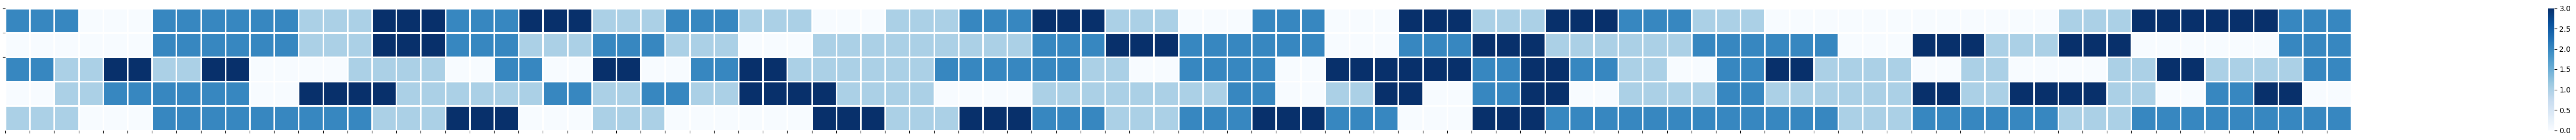

In [11]:
scheduler.visualized_single_day_schedule(scheduler.single_day_Cap(0)) # Generate a heatmap visualization depicting distribution of scheduled appointments throughout the day for different departments where the x axis is time slots during the business day and the y axis is deparments.

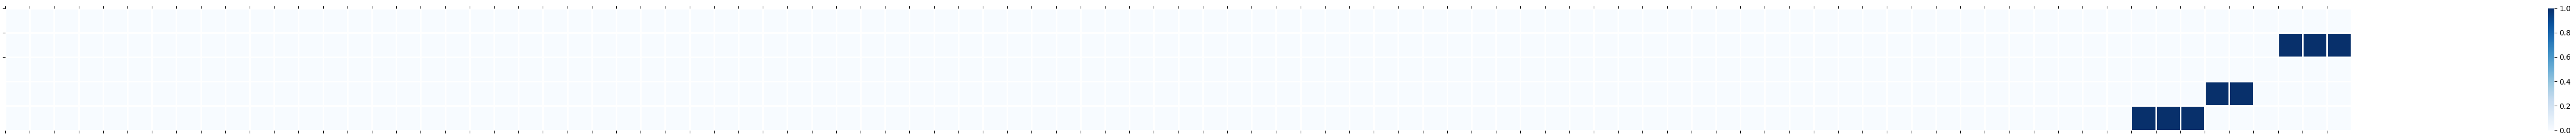

In [12]:
scheduler.visualized_single_day_schedule(res[0]['schedule']) # Visualize the first solution stored in `res` (View the optimized schedule)

In [14]:
%%time
scheduler._input(Req,obj_pref='end_time') # Prioritize end time or lead time in the objective function
res = scheduler.solve()
# Restore warning filters
# warnings.filterwarnings("default", category=UserWarning, module="pulp")

CPU times: user 150 ms, sys: 5.29 ms, total: 156 ms
Wall time: 4.7 s


In [15]:
res[0]['variables']['total_travel_t'].value() # Get total travel time from the first solution

1.0

In [16]:
res[0]['variables']['spread_t'].value() # Get total spread time from the first solution

12.0

In [17]:
res[0]['program'].objective.value() # Get the actual value of the objective function

-0.23000000000000004

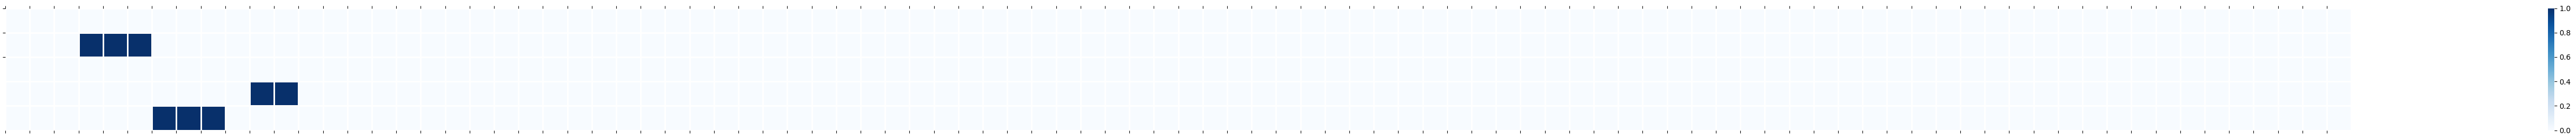

In [18]:
scheduler.visualized_single_day_schedule(res[0]['schedule']) # Visualize the first optimized schedule solution

In [19]:
### Other inputs to be considered, which can be configured in a user interface:
# Order constraint: some appointments may need to happen in a specific order. Ex: visit type 1 comes first
order_pref = np.array([[-1,1,-1],
              [0,-1,0],
              [-1,1,-1]])

# Same day constraint: some appointments may need to happen on the same day. Ex: visit type 0 and vist type 1 should always be scheduled on the same day
same_date = np.array([[-1,1,-1],
              [1,-1,-1],
              [-1,-1,-1]])


In [20]:
scheduler._input(Req,order_pref=order_pref,same_date=same_date) # Get solutions given the order and same day constraint
res = scheduler.solve()

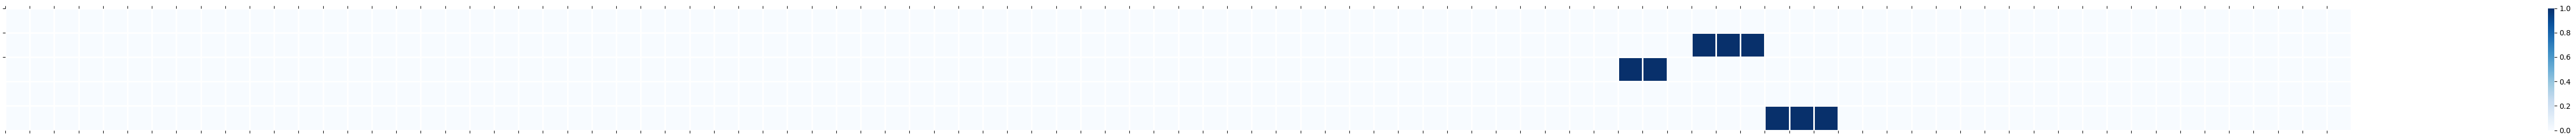

In [21]:
scheduler.visualized_single_day_schedule(res[0]['schedule']) # Visualize the optimized schedule based on the first solution stored in res, where we've set made sure visit type 1 comes first and visit tupe 0 and 1 must happen on the same day